# Natural Language Processing - Unsupervised Topic Modeling with Reddit Posts

###### This project dives into multiple techniques used for NLP and subtopics such as dimensionality reduction, topic modeling, and clustering.

1. [Google BigQuery](#Google-BigQuery)
1. [Exploratory Data Analysis (EDA) & Preprocessing](#Exploratory-Data-Analysis-&-Preprocessing)
1. [Singular Value Decomposition (SVD)](#Singular-Value-Decomposition-(SVD))
1. [Latent Semantic Analysis (LSA - applied SVD)](#Latent-Semantic-Analysis-(LSA))
1. [Similarity Scoring Metrics](#sim)
1. [KMeans Clustering](#km)
1. [Latent Dirichlet Allocation (LDA)](#lda)
1. [pyLDAvis - interactive d3 for LDA](#py)
 - This was separated out in a new notebook to quickly view visual (load files and see visualization)

In [1]:
# Easter Egg to start your imports
#import this 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import logging
import pickle
import sys
import os

from google.cloud import bigquery

In [35]:
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

# Logging is the verbose for Gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#plt.style.available # Style options
plt.style.use('fivethirtyeight')
sns.set_context("talk")
%matplotlib inline

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
pd.options.display.max_colwidth = 99
#pd.describe_option('display') # Option settings

float_formatter = lambda x: "%.3f" % x if x>0 else "%.0f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
pd.set_option('display.float_format', float_formatter)

## Google BigQuery

In [3]:
%%time

path = os.getcwd()+"/NLP-Reddit/data/posts5000.pkl"
df = pd.read_pickle(path)
df.info(memory_usage='Deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   created_utc   5000 non-null   float64
 1   subreddit     5000 non-null   object 
 2   author        4999 non-null   object 
 3   domain        5000 non-null   object 
 4   url           5000 non-null   object 
 5   num_comments  5000 non-null   int64  
 6   score         5000 non-null   int64  
 7   title         5000 non-null   object 
 8   selftext      5000 non-null   object 
 9   id            5000 non-null   object 
 10  gilded        5000 non-null   int64  
 11  over_18       5000 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 434.7+ KB
CPU times: total: 62.5 ms
Wall time: 434 ms


## Exploratory Data Analysis & Preprocessing

In [4]:
# Exploring data by length of .title or .selftext
df[[ True if 500 < len(x) < 800 else False for x in df.selftext ]].sample(3, replace=False)
# df[[ True if 500 < len(x) < 800 else False for x in df.selftext ]]

,created_utc,subreddit,author,domain,url,num_comments,score,title,selftext,id,gilded,over_18
3128,1684822267.000,malaysia,ondeonde123,self.malaysia,https://www.reddit.com/r/malaysia/comments/13pfwn8/how_did_you_save_your_first_rm100k_in_malaysia/,211,191,How did you save your first RM100k in Malaysia?,Brief bout me: \n* In my early 30s\n* Corporate slave with a monthly pay of about <RM10k\n* Mor...,13pfwn8,0,False
1340,1684797151.000,PokemonScarletViolet,ScepticalSquid,i.redd.it,https://i.redd.it/7y8al6kxai1b1.png,25,691,"A few people asked about it, here is a list of the specific pokemon to look out for during Herb...",This a list of Pokemon in 5 and 6 Star raids that drop HM at a much higher rate. The average go...,13p6q5w,0,False
2594,1684819851.000,masterduel,BuildingNo8414,i.redd.it,https://i.redd.it/aksrr6mf6k1b1.jpg,70,145,Third ever game and I died before my second turn?,"As title suggests, I somehow lost the game at insane speeds. I watched a whole episode of this ...",13pf580,0,False


In [5]:
%%time
run = False
path = '/home/User/data/gif'

# Run through various selftext lengths and save the plots of the distribution of the metric
# Gif visual after piecing all the frames together
while run==True:
    for i in range(500,20000,769):
        tempath = os.path.join(path, f"textlen{i}.png") # PEP498 requires python 3.6
        print(tempath)

        # Look at histogram of posts with len<i
        cuts = [len(x) for x in df.selftext if len(x)<i]

        # Save plot
        plt.figure()
        plt.hist(cuts, bins=30) #can change bins based on function of i
        plt.savefig(tempath, dpi=120, format='png', bbox_inches='tight', pad_inches=0.1)
        plt.close()

CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
# Bin Settings
def binSize(lower, upper, buffer=.05):
    bins = upper - lower
    buffer = int(buffer*bins)
    bins -= buffer
    print('Lower Bound:', lower)
    print('Upper Bound:', upper)
    return bins, lower, upper

# Plotting 
def plotHist(tmp, bins, title, xlabel, ylabel, l, u):
    plt.figure(figsize=(10,6))
    plt.hist(tmp, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(lower + l, upper + u)
    print('\nLocal Max %s:' % xlabel, max(tmp))
    print('Local Average %s:' % xlabel, int(np.mean(tmp)))
    print('Local Median %s:' % xlabel, int(np.median(tmp)))

Lower Bound: 0
Upper Bound: 175

Local Max Scoring: 175
Local Average Scoring: 113
Local Median Scoring: 112


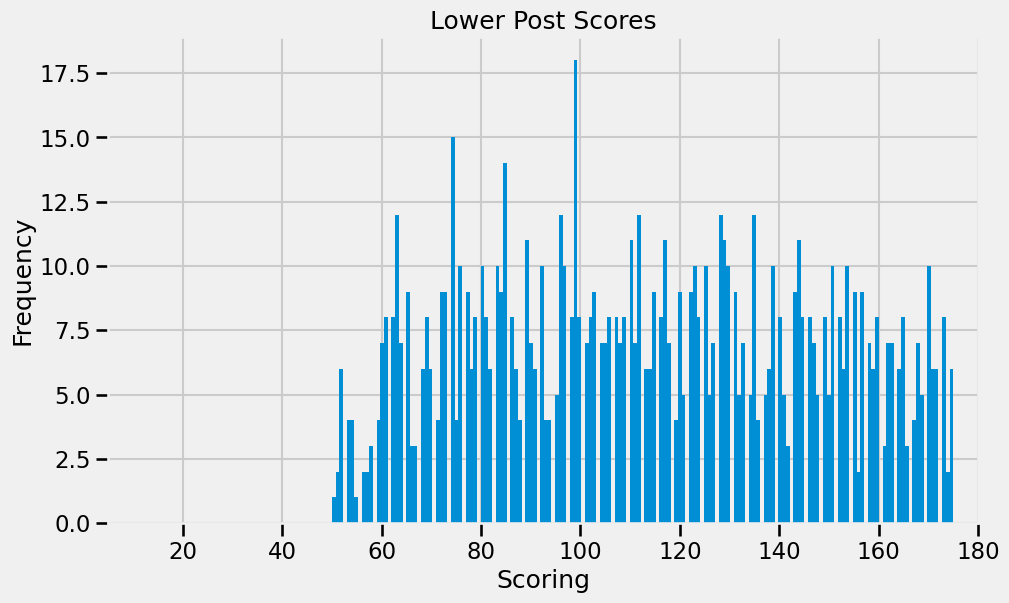

In [7]:
# Create the correct bin size
bins, lower, upper = binSize(lower=0, upper=175)

# Plot distribution of lower scores
tmp = df[[ True if lower <= x <= upper else False for x in df['score'] ]]['score']
plotHist(tmp=tmp, bins=bins, title='Lower Post Scores', xlabel='Scoring', ylabel='Frequency', l=5, u=5);

Lower Bound: 0
Upper Bound: 300

Local Max Length: 300
Local Average Length: 52
Local Median Length: 38


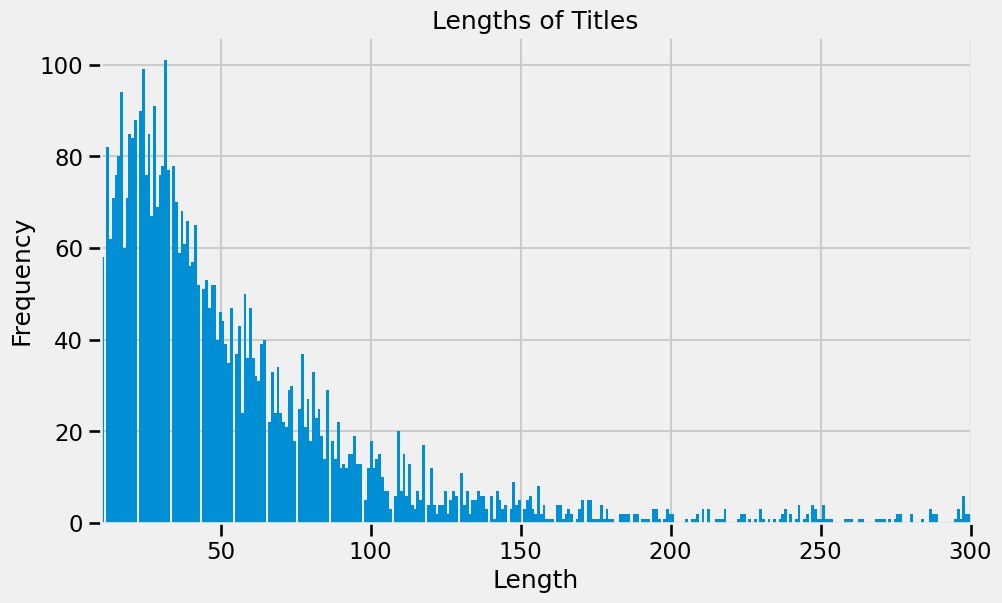

In [8]:
# Titles should be less than 300 charcters 
# Outliers are due to unicode translation
# Plot lengths of titles
tmp = [ len(x) for x in df.title ]
bins, lower, upper = binSize(lower=0, upper=300, buffer=-.09)

plotHist(tmp=tmp, bins=bins, title='Lengths of Titles', xlabel='Length', ylabel='Frequency', l=10, u=0);

Lower Bound: 500
Upper Bound: 5000

Local Max Length: 4926
Local Average Length: 1462
Local Median Length: 1098


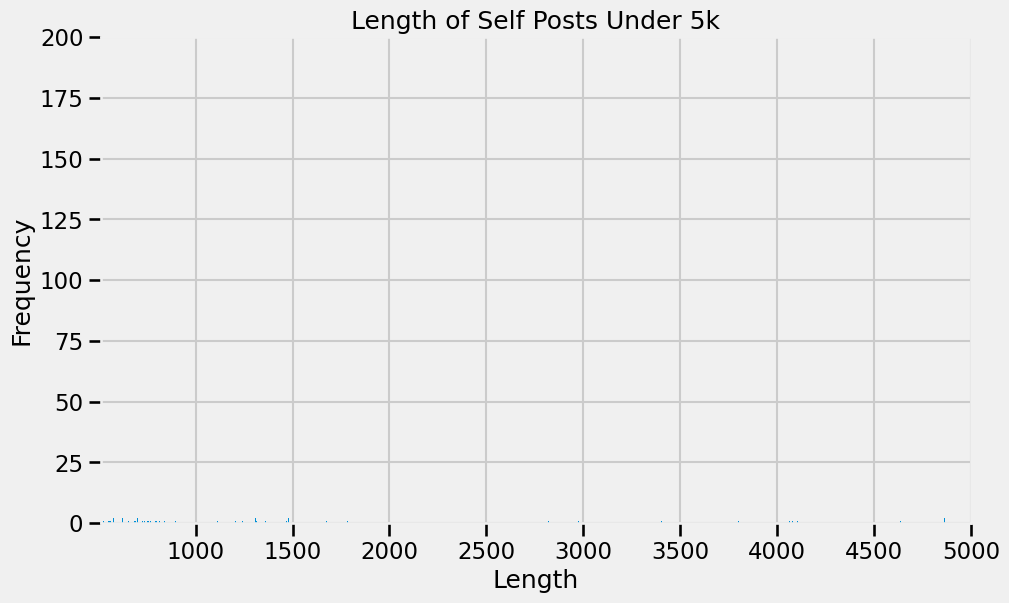

In [9]:
# Slice lengths of texts and plot histogram
bins, lower, upper = binSize(lower=500, upper=5000, buffer=.011)
tmp = [len(x) for x in df.selftext if lower <= len(x) <= upper]

plotHist(tmp=tmp, bins=bins, title='Length of Self Posts Under 5k', xlabel='Length', ylabel='Frequency', l=10, u=0)
plt.ylim(0, 200);

# Anomalies could be attributed to bots or duplicate reposts

Subreddits: 12
Total Posts: 28430
Total Posts from Top 100: 28430 , 1.000 of Total
Total Posts from Top 10: 28423 , 1.000 of Total

Top 10 Contributors: id              4567
url             4540
title           4477
created_utc     4426
author          4279
score           2229
subreddit       2122
selftext         761
num_comments     582
domain           440
dtype: int64


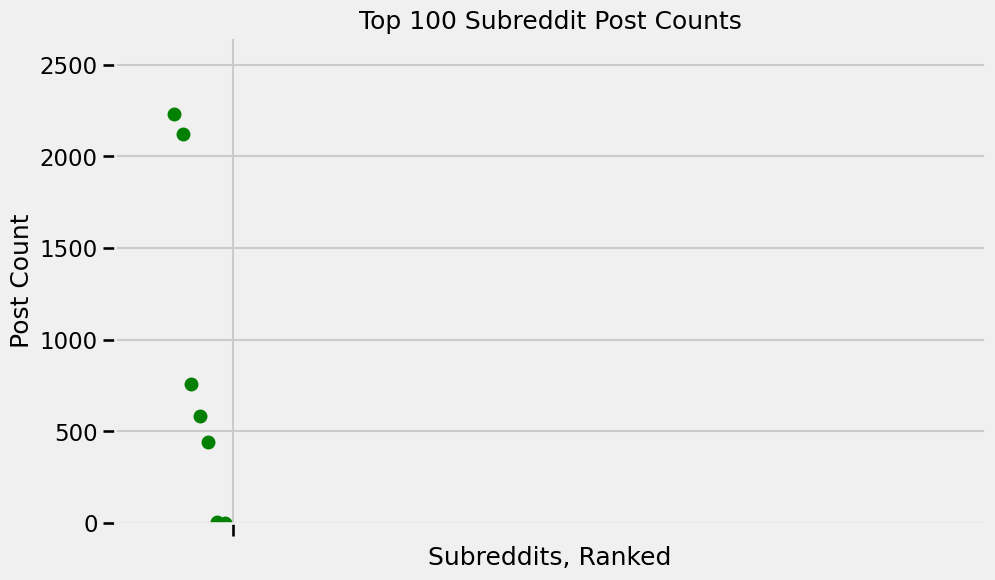

In [10]:
# Posts per Subreddit
# tmp = df.groupby('subreddit').nunique().sort_values(ascending=False)
# tmp = df.groupby('subreddit')['id'].nunique().sort_values(ascending=False)
tmp = df.nunique().sort_values(ascending=False)
top = 100
s = sum(tmp)
print('Subreddits:', len(tmp))
print('Total Posts:', s)
print('Total Posts from Top %s:' % top, sum(tmp[:top]), ', %.3f of Total' % (sum(tmp[:top])/s))
print('Total Posts from Top 10:', sum(tmp[:10]), ', %.3f of Total' % (sum(tmp[:10])/s))
print('\nTop 10 Contributors:', tmp[:10])



plt.figure(figsize=(10,6))
plt.plot(tmp, 'go')
plt.xticks('')
plt.title('Top %s Subreddit Post Counts' % top)
plt.xlabel('Subreddits, Ranked')
plt.ylabel('Post Count')    
plt.xlim(-2, top+1)
plt.ylim(0, 2650);

In [11]:
path1 = os.getcwd()+'/NLP-Reddit/data/origin.pkl'
#path2 = os.getcwd()+'/NLP-Reddit/data/grouped.pkl'

# Save important data
origin_df = df.loc[:,['created_utc', 'subreddit', 'author', 'title', 'selftext', 'id']] \
              .copy().reset_index().rename(columns={"index": "position"})
print(origin_df.info())
origin_df.to_pickle(path1)

posts_df = origin_df.loc[:,['title', 'selftext']]
posts_df['text'] = posts_df.title + ' ' + df.selftext
#del origin_df

# To group the results later
def groupUserPosts(x):
    ''' Group users' id's by post '''
    return pd.Series(dict(ids = ", ".join(x['id']),                    
                          text = ", ".join(x['text'])))

###df = posts_df.groupby('author').apply(groupUserPosts) 
#df.to_pickle(path2)

df = posts_df.text.to_frame()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   position     5000 non-null   int64  
 1   created_utc  5000 non-null   float64
 2   subreddit    5000 non-null   object 
 3   author       4999 non-null   object 
 4   title        5000 non-null   object 
 5   selftext     5000 non-null   object 
 6   id           5000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 273.6+ KB
None


In [12]:
origin_df.sample(2).drop('author', axis=1)

,position,created_utc,subreddit,title,selftext,id
2272,2272,1684794457.000,Palestine,Dammi Falastini is back on Spotify,👏🏻🔥,13p5kjg
239,239,1684799468.000,LeagueOfMemes,i forgor my pills again,,13p7nzi


In [13]:
%%time
def clean_text(df, text_field):
    '''
    Clean all the text data within a certain text column of the dataFrame.
    '''
    df[text_field] = df[text_field].str.replace(r"http\S+", " ")
    df[text_field] = df[text_field].str.replace(r"&[a-z]{2,4};", "")
    df[text_field] = df[text_field].str.replace("\\n", " ")
    df[text_field] = df[text_field].str.replace(r"#f", "")
    df[text_field] = df[text_field].str.replace(r"[\’\'\`\":]", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9]", " ")
    df[text_field] = df[text_field].str.replace(r" +", " ")
    df[text_field] = df[text_field].str.lower()
    
clean_text(df, 'text')

CPU times: total: 0 ns
Wall time: 85.5 ms


In [14]:
df.sample(3)

,text
27,til that lower class germans are stereotyped as giving their children names that sound exotic i...
907,more msm gamestop fud!
1709,cuuuute donkeys


In [15]:
# For exploration of users
df[origin_df.author == '<Redacted>'][:3]

# User is a post summarizer and aggregator, added /r/tldr to the blocked list!

,text


Lower Bound: 500
Upper Bound: 5000

Local Max Lengths: 4967
Local Average Lengths: 1452
Local Median Lengths: 1098


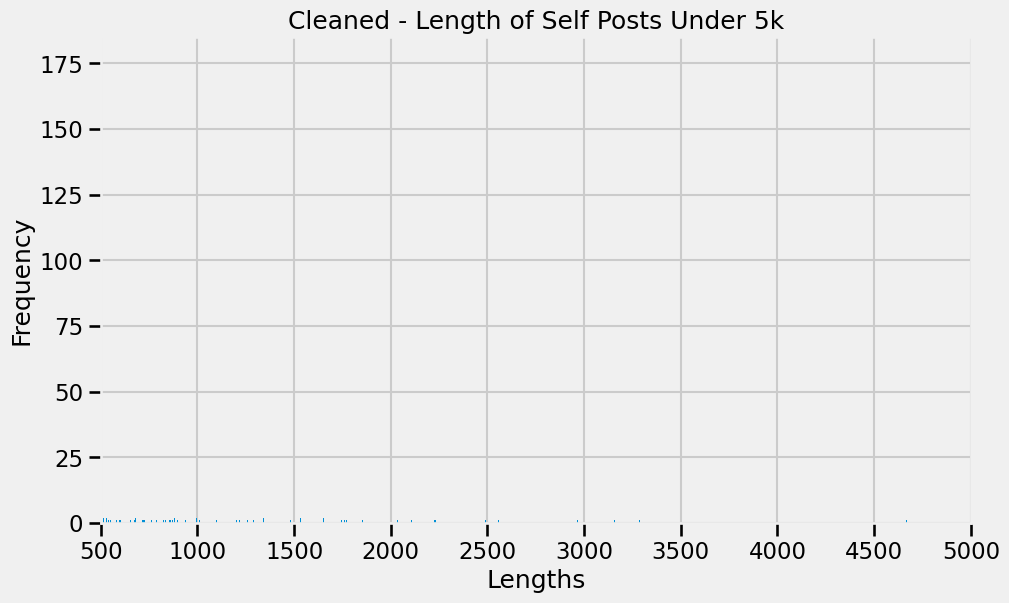

In [16]:
# Slice lengths of texts and plot histogram
bins, lower, upper = binSize(lower=500, upper=5000, buffer=.015)
tmp = [len(x) for x in df.text if lower <= len(x) <= upper]

plotHist(tmp=tmp, bins=bins, title='Cleaned - Length of Self Posts Under 5k', 
         xlabel='Lengths', ylabel='Frequency', l=0, u=0)
plt.ylim(0, 185);

In [17]:
# Download everything for nltk! ('all')
import nltk
nltk.download() # (Change config save path)
nltk.data.path.append('/home/User/data/')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [18]:
from nltk.corpus import stopwords

# "stopeng" is our extended list of stopwords for use in the CountVectorizer
# I could spend days extending this list for fine tuning results
stopeng = stopwords.words('english')
stopeng.extend([x.replace("\'", "") for x in stopeng])
stopeng.extend(['nbsp', 'also', 'really', 'ive', 'even', 'jon', 'lot', 'could', 'many'])
stopeng = list(set(stopeng))

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count vectorization for LDA
cv = CountVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                     stop_words=stopeng, ngram_range=(1,1), lowercase=False,
                     dtype='uint8')

# Vectorizer object to generate term frequency-inverse document frequency matrix
tfidf = TfidfVectorizer(token_pattern='\\w{3,}', max_df=.30, min_df=.0001, 
                        stop_words=stopeng, ngram_range=(1,1), lowercase=False,
                        sublinear_tf=True, smooth_idf=False, dtype='float32')

###### Tokenization is one of the most important steps in NLP, I will explain some of my parameter choices in the README. CountVectorizer was my preferred choice. I used these definitions to help me in the iterative process of building an unsupervised model.

###### The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

###### Smooth = False: The effect of adding “1” to the idf in the equation above is that terms with zero idf, i.e., terms that occur in all documents in a training set, will not be entirely ignored.

###### sublinear_tf = True: “l” (logarithmic), replaces tf with 1 + log(tf)

In [20]:
%%time
# Count & tf-idf vectorizer fits the tokenizer and transforms data into new matrix
cv_vecs = cv.fit_transform(df.text).transpose()
tf_vecs = tfidf.fit_transform(df.text).transpose()
pickle.dump(cv_vecs, open(os.getcwd()+'/NLP-Reddit/data/cv_vecs.pkl', 'wb'))

# Checking the shape and size of the count vectorizer transformed matrix
# 47,317 terms
# 146996 documents
print("Sparse Shape:", cv_vecs.shape) 
print('CV:', sys.getsizeof(cv_vecs))
print('Tf-Idf:', sys.getsizeof(tf_vecs))

Sparse Shape: (17797, 5000)
CV: 48
Tf-Idf: 48
CPU times: total: 391 ms
Wall time: 770 ms


In [21]:
# IFF using a subset can you store these in a Pandas DataFrame/

#tfidf_df = pd.DataFrame(tf_vecs.transpose().todense(), columns=[tfidf.get_feature_names()]).astype('float32')
#cv_df = pd.DataFrame(cv_vecs.transpose().todense(), columns=[cv.get_feature_names()]).astype('uint8')

#print(cv_df.info())
#print(tfidf_df.info())

In [22]:
#cv_description = cv_df.describe().T
#tfidf_description = tfidf_df.describe().T

#tfidf_df.sum().sort_values(ascending=False)

In [23]:
# Explore the document-term vectors
#cv_description.sort_values(by='max', ascending=False)
#tfidf_description.sort_values(by='mean', ascending=False)

## Singular Value Decomposition (SVD)

In [24]:
#from sklearn.utils.extmath import randomized_svd

# Randomized SVD for extracting the full decomposition
#U, Sigma, VT = randomized_svd(tf_vecs, n_components=8, random_state=42)

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

def Trunc_SVD(vectorized, n_components=300, iterations=1, normalize=False, random_state=42):
    """
    Performs LSA/LSI on a sparse document term matrix, returns a fitted, transformed, (normalized) LSA object
    """
    # Already own the vectorized data for LSA, just transpose it back to normal
    vecs_lsa = vectorized.T

    # Initialize SVD object as LSA
    lsa = TruncatedSVD(n_components=n_components, n_iter=iterations, algorithm='randomized', random_state=random_state)
    dtm_lsa = lsa.fit(vecs_lsa)
    print("Explained Variance - LSA {}:".format(n_components), dtm_lsa.explained_variance_ratio_.sum())
    if normalize:
        dtm_lsa_t = lsa.fit_transform(vecs_lsa)
        dtm_lsa_t = Normalizer(copy=False).fit_transform(dtm_lsa_t)
        return dtm_lsa, dtm_lsa_t
    return dtm_lsa


def plot_SVD(lsa, title, level=None):
    """
    Plots the singular values of an LSA object
    """
    plt.figure(num=1, figsize=(15,10))
    plt.suptitle(title, fontsize=22, x=.55, y=.45, horizontalalignment='left')
    plt.subplot(221)
    plt.title('Explained Variance by each Singular Value')
    plt.plot(lsa.explained_variance_[:level])
    
    plt.subplot(222)
    plt.title('Explained Variance Ratio by each Singular Value')
    plt.plot(lsa.explained_variance_ratio_[:level])
    
    plt.subplot(223)
    plt.title("Singular Values ('Components')")
    plt.plot(lsa.singular_values_[:level])
    plt.show()

Explained Variance - LSA 350: 0.8253147819313076


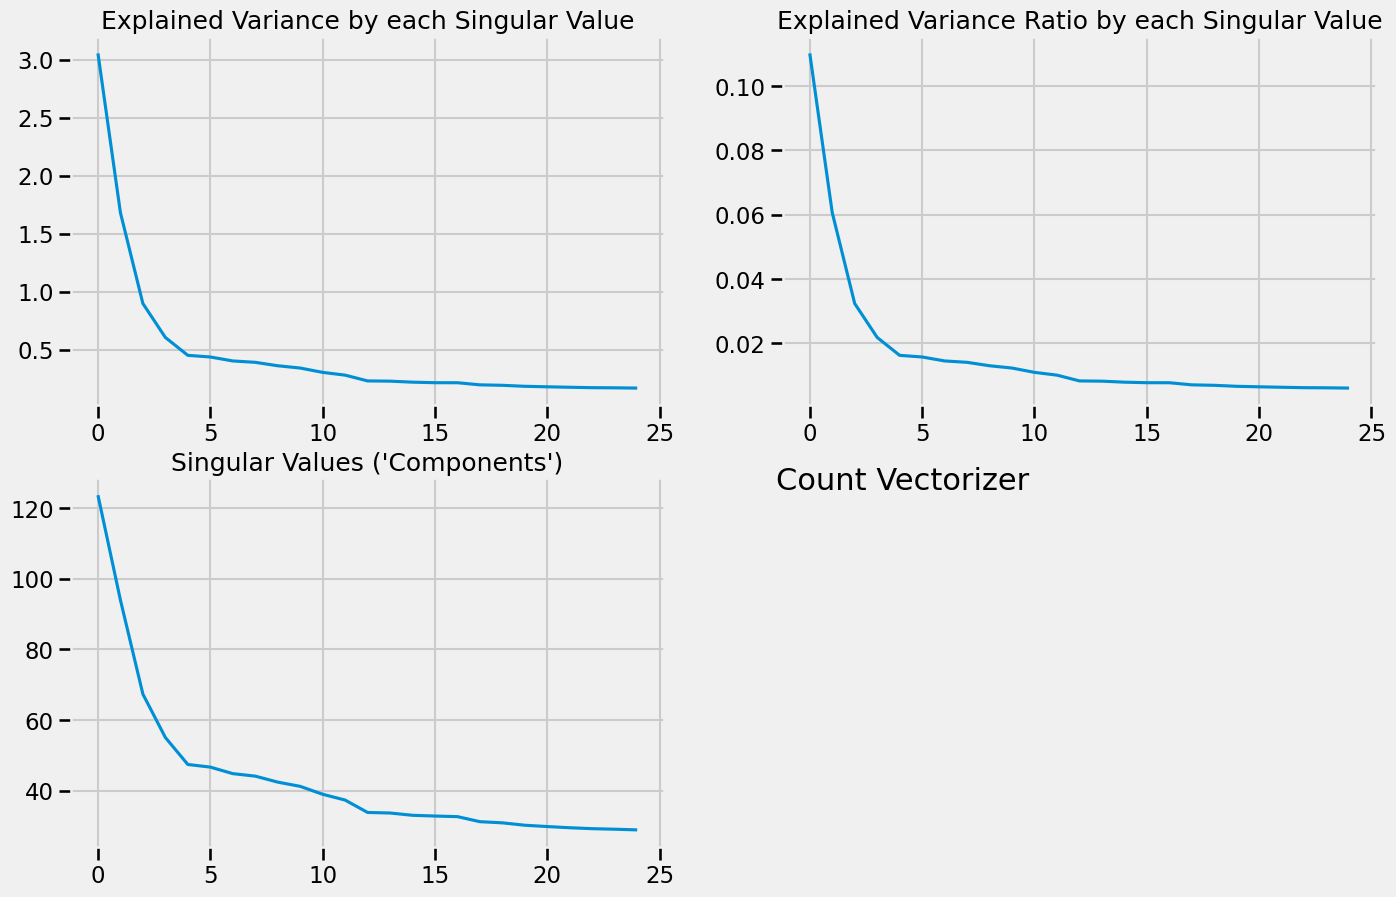

Explained Variance - LSA 350: 0.2911471


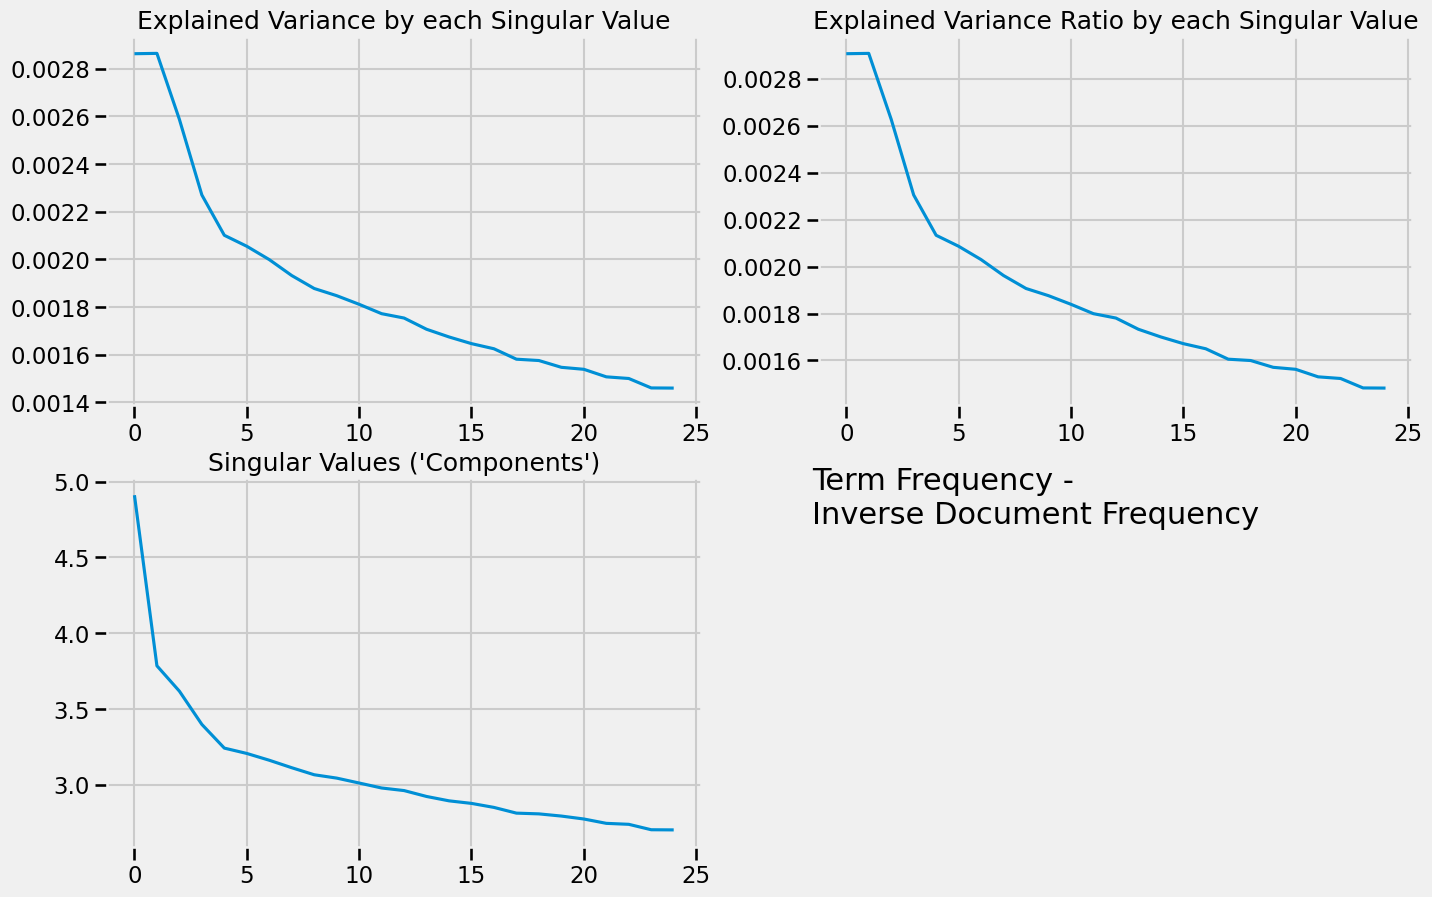

CPU times: total: 36.2 s
Wall time: 24.3 s


In [26]:
%%time
components = 350
cv_dtm_lsa = Trunc_SVD(cv_vecs, n_components=components, iterations=5, normalize=False)
plot_SVD(cv_dtm_lsa, title='Count Vectorizer', level=25)

tf_dtm_lsa = Trunc_SVD(tf_vecs, n_components=components, iterations=5, normalize=False)
plot_SVD(tf_dtm_lsa, title='Term Frequency - \nInverse Document Frequency', level=25)

In [27]:
# Numerically confirming the elbow in the above plot
print('SVD Value| CV | TFIDF')
print('Top 2:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:2])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:2])),3))
print('Top 3:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:3])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:3])),3))
print('Top 4:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:4])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:4])),3))
print('Top 5:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:5])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:5])),3))
print('Top 6:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:6])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:6])),3))
print('Top 7:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:7])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:7])),3))
print('Top 8:  ',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:8])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:8])),3))
print('Top 16:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:16])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:16])),3))
print('Top 32:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:32])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:32])),3))
print('Top 64:\t',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:64])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:64])),3))
print('Top 128:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:128])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:128])),3))
print('Top 256:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:256])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:256])),3))
print('Top 350:',round(sum(list(cv_dtm_lsa.explained_variance_ratio_[:350])),3),round(sum(list(tf_dtm_lsa.explained_variance_ratio_[:350])),3))

SVD Value| CV | TFIDF
Top 2:   0.171 0.006
Top 3:   0.203 0.008
Top 4:   0.225 0.011
Top 5:   0.241 0.013
Top 6:   0.257 0.015
Top 7:   0.271 0.017
Top 8:   0.285 0.019
Top 16:	 0.364 0.033
Top 32:	 0.461 0.057
Top 64:	 0.57 0.096
Top 128: 0.685 0.155
Top 256: 0.788 0.242
Top 350: 0.825 0.291


In [29]:
# Close look at the elbow plots
def elbow(dtm_lsa):
    evr = dtm_lsa.explained_variance_ratio_[:20]
    print("Explained Variance Ratio (EVR):\n", evr)
    print("Difference in EVR (start 3):\n", np.diff(evr[2:]))
    plt.figure()
    plt.plot(-np.diff(evr[2:]))
    plt.xticks(range(-1,22), range(2,20))
    plt.suptitle('Difference in Explained Variance Ratio', fontsize=15);
    plt.title('Start from 3, moves up to 20');

# Count Vectorizer
# elbow(cv_dtm_lsa)

In [31]:
# Tf-Idf
# elbow(tf_dtm_lsa)

###### The count vectorizer seems like it will be more fool proof, so I will use cv for my study. 8 might be a good cutoff value for the number of components kept in dimensionality reduction, I will try to confirm this later with KMeans clustering. The intuition behind this is that the slope after the 8th element is significantly different from the first elements. Keeping just 2 components would not be sufficient enough for clustering because we want to retain as much information as we can while still cutting down the dimensions to find some kind of human readable latent concept space.

###### I am going to try out 2 quick methods before clustering and moving onto my main goal of topic modeling with LDA.

## Latent Semantic Analysis (LSA)

In [34]:
%%time
from gensim import corpora, matutils, models

# Convert sparse matrix of term-doc counts to a gensim corpus
cv_corpus = matutils.Sparse2Corpus(cv_vecs)
pickle.dump(cv_corpus, open(os.getcwd()+'/NLP-Reddit/data/cv_corpus.pkl', 'wb'))

# Maps index to term
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# This is for Python 3, Need this for something at the end
id2word = corpora.Dictionary.from_corpus(cv_corpus, id2word=id2word)
pickle.dump(lda, open(os.getcwd()+'/NLP-Reddit/data/id2word.pkl', 'wb'))

# Fitting an LSI model
lsi = models.LsiModel(corpus=cv_corpus, id2word=id2word, num_topics=10)

2023-05-24 18:01:55,239 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-05-24 18:01:55,610 : INFO : built Dictionary<17797 unique tokens: ['giveaway', 'wanted', 'put', 'positive', 'message']...> from 5000 documents (total 73205 corpus positions)


NameError: name 'lda' is not defined

In [ ]:
%%time
# Retrieve vectors for the original cv corpus in the LS space ("transform" in sklearn)
lsi_corpus = lsi[cv_corpus]

# Dump the resulting document vectors into a list
doc_vecs = [doc for doc in lsi_corpus]

CPU times: user 16.1 s, sys: 1.35 s, total: 17.4 s
Wall time: 17.4 s


In [ ]:
doc_vecs[0][:5]

[(0, 1.9446177766541766),
 (1, -2.4106649569930907),
 (2, 1.2682259525175852),
 (3, 2.1424905719310936),
 (4, -1.4078167012796912)]

In [ ]:
# Sum of a documents' topics (?)
for i in range(5):
    print(sum(doc_vecs[i][1]))

-1.4106649569930907
-0.031444038368904303
-1.2723604749491777
0.15042521472269477
0.690384834127101


## <a id='sim'></a> Similarity Scoring

In [ ]:
from gensim import similarities

# Create an index transformer that calculates similarity based on our space
index = similarities.MatrixSimilarity(doc_vecs, num_features=300)

# Return the sorted list of cosine similarities to the docu document
docu = 5 # Change docu as needed
sims = sorted(enumerate(index[doc_vecs[docu]]), key=lambda item: -item[1])
np.r_[sims[:10] , sims[-10:]]

2018-03-11 06:05:35,806 : INFO : creating matrix with 146996 documents and 300 features


array([[5.0000, 1.0000],
       [30657.0000, 0.9876],
       [22319.0000, 0.9860],
       [8091.0000, 0.9858],
       [113679.0000, 0.9856],
       [26449.0000, 0.9843],
       [107391.0000, 0.9841],
       [120944.0000, 0.9837],
       [128853.0000, 0.9836],
       [24683.0000, 0.9836],
       [137752.0000, -0],
       [8740.0000, -0],
       [20137.0000, -0],
       [135470.0000, -0],
       [131917.0000, -0],
       [145455.0000, -0],
       [61673.0000, -0],
       [38001.0000, -0],
       [8408.0000, -0],
       [126462.0000, -0]])

In [ ]:
# Viewing similarity of top documents
top = 1
for sim_doc_id, sim_score in sims[:top + 1]: 
    print("\nScore:", sim_score)
    print("Document Text:\n", df.text[sim_doc_id])


Score: 0.99999994
Document Text:
 I just recharged the A/C on my 2008 328xi Just wanted to share my success story.

This was an extremely easy project, after about 10 minutes of research.

The most difficult part was knowing which knob was the low-pressure service knob. After I convinced myself I had it right, the entire thing was smooth sailing.

I was a little disappointed about the lack of specific directions on the interwebs, but there was enough for me to complete this successfully.

I had NO cold air at all. The entire thing just blew hot air with all the recommended settings. Since it's now 103 degrees here in Boulder, CO, I figured it was time.

I bought the hose/gauge and can of refrigerant at an o'reilly's auto parts store. 

Here are the steps I took to check the pressure of the system:

DISCLAIMER: I know very little about engine systems. However, I do have a little bit of gumption and a can-do attitude.

1. Let car run for 3 minutes with A/C at max, with recycled air sett

###### The metrics look artifically high, and do not match well for each document. The similarity method could be used to optimize keyword search if we were trying to expand the reach of a certain demographic using these rankings. The next step would be to improve on this method with word2vec or a better LSI model.

# <a id='km'></a>KMeans Clustering

In [ ]:
lsi_red = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()
print('Reduced LS space shape:', lsi_red.shape)
print('Reduced LS space size in bytes:', sys.getsizeof(lsi_red))

# Taking a subset for Kmeans due to memory dropout
lsi_red_sub = lsi_red.copy()
np.random.shuffle(lsi_red_sub)
lsi_red_sub = lsi_red_sub[:30000]
lsi_red_sub = Normalizer(copy=False).fit_transform(lsi_red_sub) # Normalized for the Euclidean metric
print('Reduced LS space subset shape:', lsi_red_sub.shape)
print('Reduced LS space subset size in bytes:', sys.getsizeof(lsi_red_sub))

Reduced LS space shape: (146996, 300)
Reduced LS space size in bytes: 112
Reduced LS space subset shape: (30000, 300)
Reduced LS space subset size in bytes: 112


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Calculating Silhouette coefficients and Sum of Squared Errors
def silhouette_co(start, stop, lsi_red_sub, random_state=42, n_jobs=-2, verbose=4):
    """ 
    Input a normalized subset of a reduced dense latent semantic matrix
    Returns list of scores for plotting
    """
    SSEs = []
    Sil_coefs = []
    try_clusters = range(start, stop)
    for k in try_clusters:
        km = KMeans(n_clusters=k, random_state=random_state, n_jobs=n_jobs)
        km.fit(lsi_red_sub)
        labels = km.labels_
        Sil_coefs.append(silhouette_score(lsi_red_sub, labels, metric='euclidean'))
        SSEs.append(km.inertia_)
        if k%verbose==0:
            print(k)
    return SSEs, Sil_coefs, try_clusters

In [ ]:
%%time
SSEs, Sil_coefs, try_clusters = silhouette_co(start=2, stop=40, lsi_red_sub=lsi_red_sub)

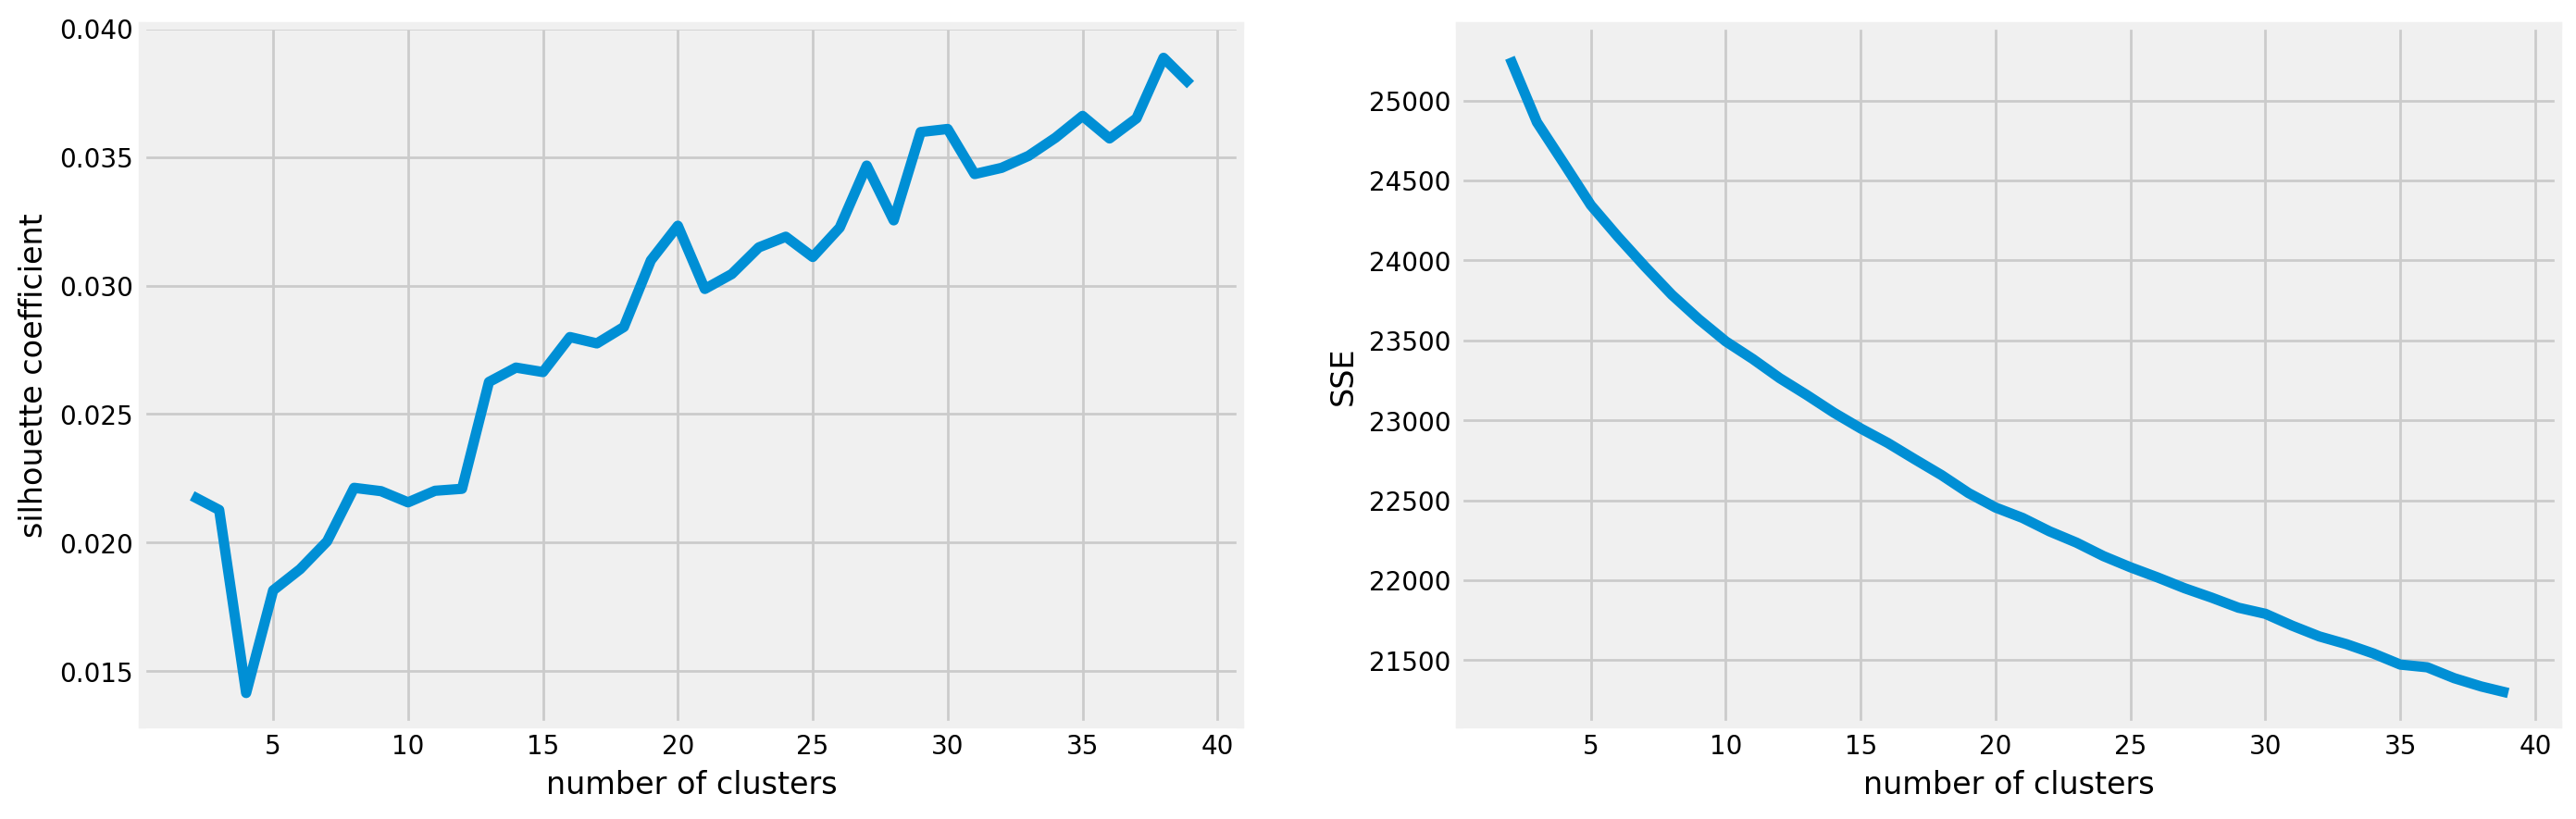

In [ ]:
def plot_sil(try_clusters, Sil_coefs, SSEs):
    """ Function for visualizing/ finding the best clustering point """
    # Plot Silhouette scores
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
    ax1.plot(try_clusters, Sil_coefs)
    ax1.title('Silhouette of Clusters')
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Silhouette Coefficient')

    # Plot errors
    ax2.plot(try_clusters, SSEs)
    ax2.title("Cluster's Error")
    ax2.set_xlabel('Number of Clusters')
    ax2.set_ylabel('SSE');
    
plot_sil(try_clusters=try_clusters, Sil_coefs=Sil_coefs, SSEs=SSes)

###### This suggests that there arent meaningful clusters in the normalized LS300 space. To test if 300 dimensions is too large, I will try clustering again with a reduced input.

In [ ]:
# Fix IndexError: index 10
lsi_red5 = matutils.corpus2dense(lsi_corpus, num_terms=10).transpose()
print('Reduced LSI space shape:', lsi_red5.shape)
print('Reduced LS space subset size in bytes:', sys.getsizeof(lsi_red5))

# Taking a subset for Kmeans due to memory dropout
lsi_red_sub5 = lsi_red5.copy()
np.random.shuffle(lsi_red_sub5)
lsi_red_sub5 = lsi_red_sub5[:5000]
lsi_red_sub5 = Normalizer(copy=False).fit_transform(lsi_red_sub5) # Normalized for the Euclidean metric
print('Reduced LSI space subset shape:', lsi_red_sub5.shape)
print('Reduced LS space subset size in bytes:', sys.getsizeof(lsi_red_sub5))

In [ ]:
%%time
SSEs, Sil_coefs, try_clusters = silhouette_co(start=2, stop=40, lsi_red_sub=lsi_red_sub)
plot_sil(try_clusters=try_clusters, Sil_coefs=Sil_coefs, SSEs=SSes)

###### Due to project deadlines, I was not able to complete this method but I wanted to preserve the effort and document the process for later use. I will move on to LDA.

In [ ]:
# Cluster with the best results
#kmeans = KMeans(n_clusters=20, n_jobs=-2)
#lsi_clusters = kmeans.fit_predict(lsi_red)

# Take a look at the 
print(lsi_clusters[0:15])
df.text[0:2]

[0 0 0 0 0 0 0 0 0 0 7 0 0 0 0]


0    MEGA Pet Adoption Event! Cats, Dogs, a bunny: only $25 - includes spay, neuter &amp; vaccines. Saturday 9-4 Melbourne Wickham Park Community Center.\n\nThis is a 'cash 'n' carry' event - you will take your animal home that day. \n\nThere will be a huge variety of sizes, ages, breeds and personalities. If you want a cat that has a dog personality, they probably have a few Maine Coon cats (imagine a cat with the personality of Snoop Dogg or Willie Nelson). If you want an older, quiet, couch-potato dog - it shouldn't be hard to find one.\n\nThis is also kitten season. You could probably pick up a six-pack if you'd like, or find a few to match your preferred color of decor. Have a favorite Coach bag? Get a cat with fur to match so the shedding doesn't show.  Huge selection. Huge. \n\nHave you longed to have a dog named Tripod or Tippy? This is your chance. No guarantees, but again, chances are good. \n\nDo you love the Buccaneers? Talk like a pirate day? Know the punchline to a pirate

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# Validating cluster performance
# Select range around best result, plot the silhouette distributions for each cluster
for k in range(14,17):
    plt.figure(dpi=120, figsize=(8,6))
    ax1 = plt.gca()
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    labels = km.labels_
    silhouette_avg = silhouette_score(X, labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, labels)
    y_lower = 100
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        
        #Sort
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## <a id='lda'></a> Latent Dirichlet Allocation (LDA)

In [ ]:
%%time
run = False

passes = 85
if run==True:
    lda = models.LdaMulticore(corpus=cv_corpus, num_topics=15, id2word=id2word, passes=passes, 
                              workers=13, random_state=42, eval_every=None, chunksize=6000)

2018-03-08 22:48:40,670 : INFO : using symmetric alpha at 0.06666666666666667
2018-03-08 22:48:40,673 : INFO : using symmetric eta at 0.06666666666666667
2018-03-08 22:48:40,689 : INFO : using serial LDA version on this node
2018-03-08 22:48:40,811 : INFO : running online LDA training, 15 topics, 100 passes over the supplied corpus of 146996 documents, updating every 78000 documents, evaluating every ~0 documents, iterating 50x with a convergence threshold of 0.001000
2018-03-08 22:48:40,815 : INFO : training LDA model using 13 processes
2018-03-08 22:48:43,307 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #6000/146996, outstanding queue size 1
2018-03-08 22:48:52,172 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #12000/146996, outstanding queue size 2
2018-03-08 22:48:58,812 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #18000/146996, outstanding queue size 3
2018-03-08 22:49:05,247 : INFO : PROGRESS: pass 0, dispatched chunk #3

2018-03-09 03:59:12,219 : INFO : PROGRESS: pass 99, dispatched chunk #11 = documents up to #72000/146996, outstanding queue size 3
2018-03-09 03:59:19,407 : INFO : PROGRESS: pass 99, dispatched chunk #12 = documents up to #78000/146996, outstanding queue size 3
2018-03-09 03:59:26,762 : INFO : PROGRESS: pass 99, dispatched chunk #13 = documents up to #84000/146996, outstanding queue size 3
2018-03-09 03:59:35,861 : INFO : PROGRESS: pass 99, dispatched chunk #14 = documents up to #90000/146996, outstanding queue size 3
2018-03-09 03:59:42,764 : INFO : merging changes from 78000 documents into a model of 146996 documents
2018-03-09 03:59:42,868 : INFO : topic #7 (0.067): 0.032*"team" + 0.017*"game" + 0.013*"match" + 0.011*"players" + 0.009*"win" + 0.009*"teams" + 0.008*"games" + 0.007*"season" + 0.007*"round" + 0.007*"play"
2018-03-09 03:59:42,873 : INFO : topic #14 (0.067): 0.011*"damage" + 0.005*"level" + 0.005*"use" + 0.004*"game" + 0.004*"attack" + 0.004*"good" + 0.003*"deck" + 0.003

CPU times: user 5h 2min 40s, sys: 11min 30s, total: 5h 14min 10s
Wall time: 5h 12min 18s


In [ ]:
# Save model after your last run, or continue to update LDA
#pickle.dump(lda, open(os.getcwd()+'/NLP-Reddit/data/lda_gensim.pkl', 'wb'))

# Gensim save
#lda.save(os.getcwd()+'/NLP-Reddit/data/gensim_lda.model')
lda =  models.LdaModel.load(os.getcwd()+'/NLP-Reddit/data/gensim_lda.model')

2018-03-11 18:37:34,480 : INFO : loading LdaModel object from data/gensim_lda.model
2018-03-11 18:37:34,484 : INFO : loading expElogbeta from data/gensim_lda.model.expElogbeta.npy with mmap=None
2018-03-11 18:37:34,489 : INFO : setting ignored attribute state to None
2018-03-11 18:37:34,490 : INFO : setting ignored attribute id2word to None
2018-03-11 18:37:34,491 : INFO : setting ignored attribute dispatcher to None
2018-03-11 18:37:34,492 : INFO : loaded data/gensim_lda.model
2018-03-11 18:37:34,493 : INFO : loading LdaState object from data/gensim_lda.model.state
2018-03-11 18:37:34,517 : INFO : loaded data/gensim_lda.model.state


In [ ]:
%%time
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[cv_corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

CPU times: user 7min 36s, sys: 12min 58s, total: 20min 34s
Wall time: 2min 20s


In [ ]:
# Review Dirichlet distribution for documents
lda_docs[25000]

[(1, 0.02299821), (2, 0.8877785), (7, 0.080621116)]

In [ ]:
# Manually review the document to see if it makes sense! 
# Look back at the topics that it matches with to confirm the result!
df.iloc[25000]

text    fun fact about call of duty the last call of duty game you enjoyed was when the series went downhill whether that was world at war black ops mw2 black ops 2 etc but seriously the games just get stale and repetitive but that doesnt mean they are bad modern warfare feels stale today but it was incredibly fresh and new for the time battlefield feels as stale as cod to me because the gameplay loop has been so refined bf3 vs bf4 that its still going to be roughly the same experience but with a different skin assassins creed is going to feel stale once youve played so many of them but for those that havent its still a new experience they can enjoy also the cod vs battlefield rivalry is incredibly childish both are different forms of arcadey shooters and neither are esports game or need to be play what you enjoy the e3 footage of cod looked pretty good and sci fi games give developers more freedom in gameplay design im a little sad that its not battlefield 2143 but i hope that will co

In [ ]:
#bow = df.iloc[1,0].split()

# Print topic probability distribution for a document
#print(lda[bow]) #Values unpack error

# Given a chunk of sparse document vectors, estimate gamma:
# (parameters controlling the topic weights) for each document in the chunk.
#lda.inference(bow) #Not enough values

# Makeup of each topic! Interpretable! 
# The d3 visualization below is far better for looking at the interpretations.
lda.print_topics(num_words=10, num_topics=1)

2018-03-11 07:47:06,762 : INFO : topic #1 (0.067): 0.005*"water" + 0.005*"food" + 0.004*"use" + 0.003*"make" + 0.003*"much" + 0.003*"used" + 0.003*"well" + 0.003*"skin" + 0.003*"first" + 0.003*"good"


[(1,
  '0.005*"water" + 0.005*"food" + 0.004*"use" + 0.003*"make" + 0.003*"much" + 0.003*"used" + 0.003*"well" + 0.003*"skin" + 0.003*"first" + 0.003*"good"')]

## <a id='py'></a> pyLDAvis

In [ ]:
# For quickstart, we can just jump straight to results
import pickle
from gensim import models
def loadingPickles():
    id2word = pickle.load(open(os.getcwd()+'/NLP-Reddit/data/id2word.pkl','rb'))
    cv_vecs = pickle.load(open(os.getcwd()+'/NLP-Reddit/data/cv_vecs.pkl','rb'))
    cv_corpus = pickle.load(open(os.getcwd()+'/NLP-Reddit/data/cv_corpus.pkl','rb'))
    lda =  models.LdaModel.load(os.getcwd()+'/NLP-Reddit/data/gensim_lda.model')
    return id2word, cv_vecs, cv_corpus, lda

In [ ]:
import pyLDAvis.gensim
import gensim

# Enables visualization in jupyter notebook
pyLDAvis.enable_notebook()

# Prepare the visualization
# Change multidimensional scaling function via mds parameter
# Options are tsne, mmds, pcoa 
# cv_corpus or cv_vecs work equally
id2word, _, cv_corpus, lda = loadingPickles()
viz = pyLDAvis.gensim.prepare(topic_model=lda, corpus=cv_corpus, dictionary=id2word, mds='mmds')

# Save the html for sharing!
pyLDAvis.save_html(viz,os.getcwd()+'/NLP-Reddit/data/viz.html')

# Interact! Saliency is the most important metric that changes the story of each topic.
pyLDAvis.display(viz)

/usr/local/lib/python3.5/dist-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


# There you have it. There is a ton of great information right here that I will conclude upon in the README and the slides on my github. 

###### In it I will discuss what I could do with this information. I did not end up using groupUserPosts but I could create user profiles based on the aggregate of their document topic distributions. I believe this is a great start to understanding NLP and how it can be used. I would consider working on this again but with more technologies needed for big data.